In [1]:
# math 
import numpy as np

# normal cdf
from scipy.stats import norm

# dataframes
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn

# linear regression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# for choosing covariates to include in model
from patsy import dmatrices 

In [2]:
usage = pd.read_csv('elec_usage.txt')
usage.head()

,month,year,usage,temperature
0,8,1989,24.828,73
1,9,1989,24.688,67
2,10,1989,19.310,57
3,11,1989,59.706,43
4,12,1989,99.667,26


In [3]:
Y, X = dmatrices('usage ~ 1 + temperature + np.power(temperature, 2)', data=usage, return_type='dataframe')
model = sm.OLS(Y, X).fit()

In [4]:
def plot_fit(Y, Yhat):
    plt.scatter(Y, Yhat,  color='black')
    plt.xlabel("true outcome Y")
    plt.ylabel("predicted outcome Yhat")

    plt.show()
    
def assess_model_quality(data, formula):
    Y, X = dmatrices(formula, data=data, return_type='dataframe')
    model = sm.OLS(Y, X).fit()
    Yhat = model.predict(X)
    plot_fit(Y, Yhat)
    return model 

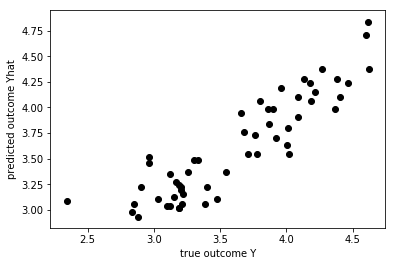

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(usage)   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     227.8
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           7.82e-21
Time:                        09:20:27   Log-Likelihood:                 1.0037
No. Observations:                  55   AIC:                             1.993
Df Residuals:                      53   BIC:                             6.007
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               9.9203      0.419     23.691      0.000       9.080      10.760
np.log(temperature)    -1.5989      0.106    -15.092      0.000      -1.811      -1.386
==============================================================================
Omnibus:                        4.773   Durbin-Watson:                   1.402
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                3.709
Skew:                          -0.551   Prob(JB):                        0.157
Kurtosis:                       3.636   Cond. No.                         53.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
# try a linear model to predict log usage from log temperature
linear = assess_model_quality(usage, 'np.log(usage) ~ np.log(temperature)')
linear.summary()

Text(0, 0.5, 'residual')

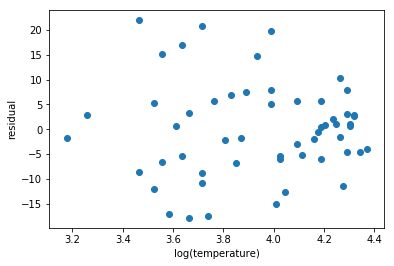

In [6]:
# is there any signal left in the residuals?
resid = model.resid
plt.scatter(np.log(usage['temperature']), model.resid)
plt.xlabel("log(temperature)")
plt.ylabel("residual")

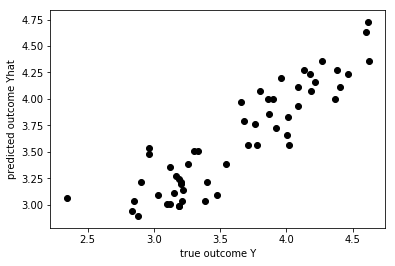

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(usage)   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     113.6
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           1.06e-19
Time:                        09:20:28   Log-Likelihood:                 1.3644
No. Observations:                  55   AIC:                             3.271
Df Residuals:                      52   BIC:                             9.293
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            5.6258      5.200      1.082      0.284      -4.809      16.061
np.log(temperature)                  0.6349      2.698      0.235      0.815      -4.779       6.049
np.power(np.log(temperature), 2)    -0.2885      0.348     -0.829      0.411      -0.987       0.410
==============================================================================
Omnibus:                        5.527   Durbin-Watson:                   1.396
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                4.464
Skew:                          -0.618   Prob(JB):                        0.107
Kurtosis:                       3.649   Cond. No.                     2.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
# let's try adding a quadratic term 
# notice we get a warning that design matrix is ill-conditioned
quad = assess_model_quality(usage, 'np.log(usage) ~ np.log(temperature) + np.power(np.log(temperature), 2)')
quad.summary()

In [8]:
# VIF for quadratic model

Y, X = dmatrices('np.log(usage) ~ np.log(temperature) + np.power(np.log(temperature), 2)', data=usage, return_type='dataframe')

pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

Intercept                           25237.650598
np.log(temperature)                   644.758755
np.power(np.log(temperature), 2)      644.758755
dtype: float64

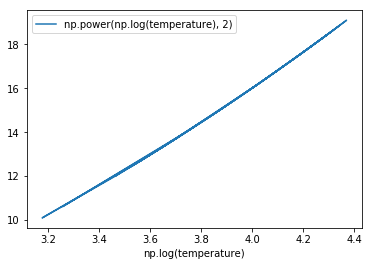

In [9]:
# the problem: collinearity
X.plot('np.log(temperature)', 'np.power(np.log(temperature), 2)')

## specific fix: use centered covariates

In [10]:
# instate the quadratic model 
Y, X = dmatrices('np.log(usage) ~ np.log(temperature) + np.power(np.log(temperature), 2)', data=usage)

In [11]:
# center the data 
X[:,1] = X[:,1] - np.mean(X[:,1])
X[:,2] = np.power(X[:,1],2)

In [12]:
# check VIFs after centering data: not too bad!
pd.Series([variance_inflation_factor(X, i) 
               for i in range(X.shape[1])])

0    2.019335
1    1.208873
2    1.208873
dtype: float64

Text(0, 0.5, 'np.power(np.log(temperature), 2)')

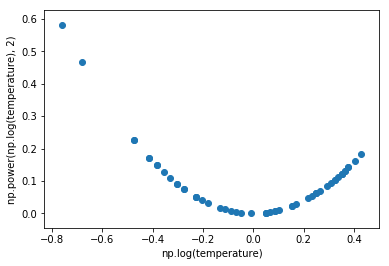

In [13]:
# no longer collinear
plt.scatter(X[:,1], X[:,2])
plt.xlabel("np.log(temperature)")
plt.ylabel("np.power(np.log(temperature), 2)")

## general fix: orthogonal polynomials

In [14]:
def ortho_poly_fit(x, degree = 1):
    n = degree + 1
    x = np.asarray(x).flatten()
    if(degree >= len(np.unique(x))):
            stop("'degree' must be less than number of unique points")
    xbar = np.mean(x)
    x = x - xbar
    X = np.fliplr(np.vander(x, n))
    q,r = np.linalg.qr(X)

    z = np.diag(np.diag(r))
    raw = np.dot(q, z)

    norm2 = np.sum(raw**2, axis=0)
    alpha = (np.sum((raw**2)*np.reshape(x,(-1,1)), axis=0)/norm2 + xbar)[:degree]
    Z = raw / np.sqrt(norm2)
    return Z, norm2, alpha

"""Use this function to transform test dataset to orthogonalized coordinates"""
def ortho_poly_predict(x, alpha, norm2, degree = 1):
    x = np.asarray(x).flatten()
    n = degree + 1
    Z = np.empty((len(x), n))
    Z[:,0] = 1
    if degree > 0:
        Z[:, 1] = x - alpha[0]
    if degree > 1:
      for i in np.arange(1,degree):
          Z[:, i+1] = (x - alpha[i]) * Z[:, i] - (norm2[i] / norm2[i-1]) * Z[:, i-1]
    Z /= np.sqrt(norm2)
    return Z

In [15]:
# create orthogonal polynomial features
Z, norm2, alpha = ortho_poly_fit(np.log(usage['temperature']), degree=2)
Y = np.log(usage['usage'])

In [16]:
# check that VIFs are 1
pd.Series([variance_inflation_factor(Z, i) 
               for i in range(Z.shape[1])])

0    1.0
1    1.0
2    1.0
dtype: float64

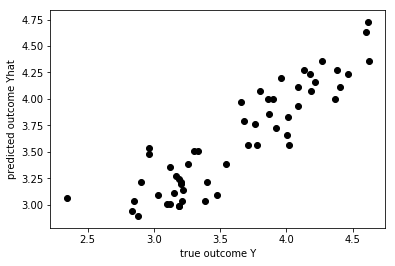

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  usage   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     113.6
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           1.06e-19
Time:                        09:20:28   Log-Likelihood:                 1.3644
No. Observations:                  55   AIC:                             3.271
Df Residuals:                      52   BIC:                             9.293
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            26.8452      0.243    110.585      0.000      26.358      27.332
x2            -3.6528      0.243    -15.047      0.000      -4.140      -3.166
x3            -0.2011      0.243     -0.829      0.411      -0.688       0.286
==============================================================================
Omnibus:                        5.527   Durbin-Watson:                   1.396
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                4.464
Skew:                          -0.618   Prob(JB):                        0.107
Kurtosis:                       3.649   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# assess model quality 
# note R^2 is the same as with original covariates, but std errors are equalized 
# p values for intercept and linear term are now highly statistically significant

model = sm.OLS(Y, Z).fit()
Yhat = model.predict(Z)
plot_fit(Y, Yhat)
model.summary()

In [18]:
# check orthogonality
np.dot(Z[:,1], Z[:,2])

-2.7755575615628914e-17

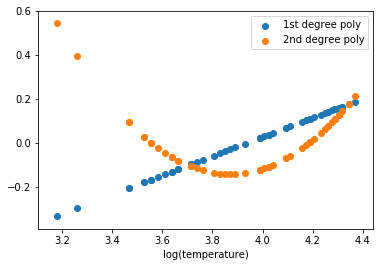

In [19]:
logtemp = np.log(usage['temperature'])
plt.scatter(logtemp, Z[:,1], label="1st degree poly")
plt.scatter(logtemp, Z[:,2], label="2nd degree poly")
plt.xlabel("log(temperature)")
plt.legend()

# Predictions

In [20]:
usage = usage.sort_values('temperature')
Y, X = dmatrices('usage ~ 1 + temperature + np.power(temperature, 2)', data=usage, return_type='dataframe')
model = sm.OLS(Y, X).fit()

In [21]:
predictions = model.get_prediction(X)
predictions.summary_frame(alpha=0.05) # alpha=0.05 -> 95% confidence interval

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
53,103.045721,4.904832,93.203456,112.887986,81.459725,124.631717
4,96.837973,4.230563,88.348727,105.327219,75.834346,117.841600
42,79.689852,2.639513,74.393282,84.986423,59.761513,99.618192
54,79.689852,2.639513,74.393282,84.986423,59.761513,99.618192
41,74.465520,2.277803,69.894775,79.036266,54.717691,94.213350
29,74.465520,2.277803,69.894775,79.036266,54.717691,94.213350
17,71.945550,2.133371,67.664628,76.226472,52.262782,91.628317
52,71.945550,2.133371,67.664628,76.226472,52.262782,91.628317
40,69.487042,2.014142,65.445370,73.528715,49.854922,89.119163
30,67.089999,1.920153,63.236929,70.943068,47.495837,86.684161


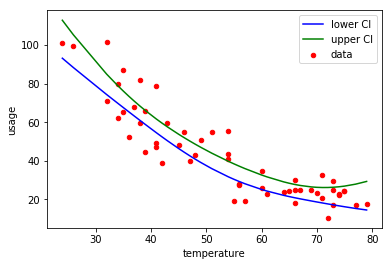

In [22]:
# plot confidence intervals 
CI = predictions.conf_int(alpha=.05)
p = usage.plot.scatter('temperature', 'usage', color='red', label='data')
p.plot(usage['temperature'], CI[:,0], color='blue', label="lower CI")
p.plot(usage['temperature'], CI[:,1], color='green', label='upper CI')
p.legend()

In [23]:
def prediction_interval(predictions, alpha=.05):
    emean = predictions.predicted_mean
    sigma = np.sqrt(predictions.var_resid)
    n = len(emean)
    PI = np.zeros((n,2))
    PI[:,0] = emean + norm.ppf(alpha/2)*sigma
    PI[:,1] = emean + norm.ppf(1-alpha/2)*sigma
    return PI

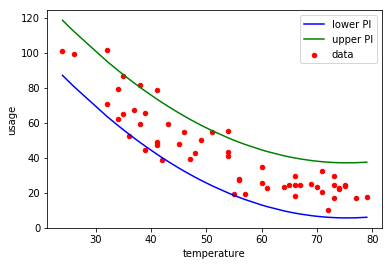

In [24]:
# plot prediction intervals 
PI = prediction_interval(predictions, alpha = .1)
p = usage.plot.scatter('temperature', 'usage', color='red', label='data')
p.plot(usage['temperature'], PI[:,0], color='blue', label="lower PI")
p.plot(usage['temperature'], PI[:,1], color='green', label='upper PI')
p.legend()

# Log transformations

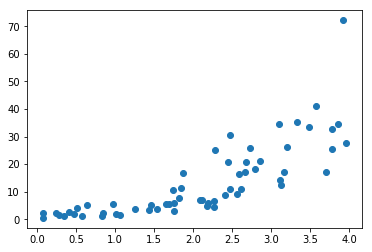

In [36]:
np.random.seed(0)
n = 60
x = 4*np.random.rand(n)
y = np.exp(x + .5*np.random.randn(n))
plt.scatter(x,y)

In [49]:
idx = np.argsort(x)
x = x[idx]
y = y[idx]

array([ 2.26887769,  0.47987694,  2.07346559,  1.45187715,  1.15908017,
        2.44214707,  1.96259686,  4.09039048,  1.14799228,  5.03819894,
        1.2826719 ,  2.3321259 ,  5.57314632,  1.89541726,  1.60905577,
        3.76282291,  3.44334413,  5.23746585,  3.86667704,  5.40179028,
        5.36839018, 10.58407328,  5.95128675,  2.9462304 ,  7.8258515 ,
       11.19668544, 16.88987119,  6.90065974,  6.92960698,  4.89990903,
        5.74035316,  6.45984358,  4.50691981, 25.08731727,  8.63350821,
       20.85873231, 10.78087326, 30.52318554,  9.18231214, 16.40756301,
       11.08534329, 17.20586063, 20.81841773, 25.90684086, 18.07739518,
       21.20440015, 34.72111493, 14.28168321, 12.2399329 , 16.95681687,
       26.07887794, 35.22903181, 33.31545125, 41.19545571, 17.10285232,
       25.52391876, 32.76139485, 34.38051554, 72.16958163, 27.61206605])

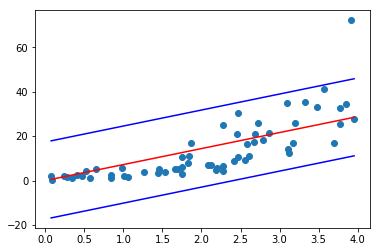

In [53]:
# use linear model - bad fit!
model = sm.OLS(y,x).fit()
predictions = model.get_prediction(x)
yhat = predictions.predicted_mean
PI = prediction_interval(predictions)
plt.scatter(x,y)
plt.plot(x,yhat,color='red')
plt.plot(x,PI[:,0],color='blue')
plt.plot(x,PI[:,1],color='blue')

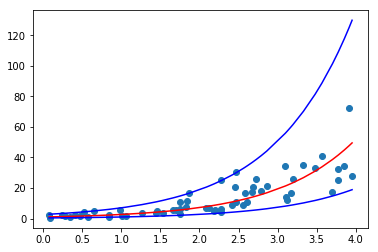

In [52]:
# use linear model with log transform
model = sm.OLS(np.log(y),x).fit()
predictions = model.get_prediction(x)
yhat = np.exp(predictions.predicted_mean)
PI = np.exp(prediction_interval(predictions))
plt.scatter(x,y)
plt.plot(x,yhat,color='red')
plt.plot(x,PI[:,0],color='blue')
plt.plot(x,PI[:,1],color='blue')